In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
import os
import operator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp  

import pandas as pd
import numpy as np


In [11]:
len(final_train.columns)

124

In [9]:
final_train = pd.read_csv("C:\\Users\\CDA\\graduated_design\\data\\final_table\\final_total_feature_174.csv")
final_feature = pd.read_csv("C:\\Users\\CDA\\graduated_design\\score\\final_feature.csv")

list_final_feature = final_feature["final_feture"].tolist()

list_final_feature.extend(["user_id"])
final_train = final_train[list_final_feature]



common_path_1 = "C:\\Users\\CDA\\graduated_design\\data\\train_data\\"
overdue_train = pd.read_table(os.path.join(common_path_1,"overdue_train.txt"),sep = ",",header = None, names = ["user_id","is_overdue"])
final_train = pd.merge(final_train,overdue_train,how = "inner",on = "user_id")
train_val_xy,offline_xy = train_test_split(final_train,test_size = 0.15,random_state = 7)
offline_x = offline_xy.drop(["user_id","is_overdue"],axis = 1)
offline_y = offline_xy["is_overdue"]

train_val_x = train_val_xy.drop(["user_id","is_overdue"],axis = 1)
train_val_y = train_val_xy["is_overdue"]

train_xy,val_xy = train_test_split(train_val_xy,test_size = 0.2,random_state = 7)
train_X = train_xy.drop(["user_id","is_overdue"],axis = 1)
train_y = train_xy["is_overdue"]
val_X = val_xy.drop(["user_id","is_overdue"],axis = 1)
val_y = val_xy["is_overdue"]

In [10]:
adabst = AdaBoostClassifier(n_estimators=500,learning_rate = 0.1,algorithm = "SAMME.R",random_state = 2)
adabst.fit(train_val_x,train_val_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=500, random_state=2)

In [12]:
pred = adabst.predict_proba(offline_x)
offline = offline_xy[["user_id"]]
offline["lgbm_prob"] = pred[:,1]
offline.to_csv("C:\\Users\\CDA\\graduated_design\\prob\\adabst_prob_112.csv",index = False,encoding = "utf-8")

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


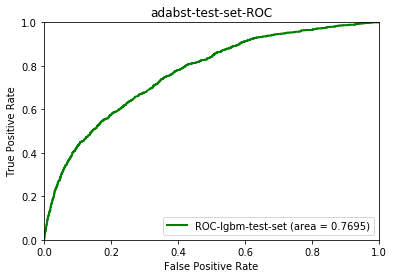

('ks', 0.3893428018814293)


In [16]:
fpr, tpr, thresholds = roc_curve(offline_y, pred[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color="g", label='ROC-lgbm-test-set (area = %0.4f)' % ( roc_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('adabst-test-set-ROC')
plt.legend(loc='lower right')
plt.savefig("adbst-test-set-ROC")
plt.show()
print(ks(pred[:,1], offline_y))

In [14]:
ks(pred[:,1], offline_y)

('ks', 0.3893428018814293)

('ks', 0.39591438448915867)
('ks', 0.39640666571078076)
('ks', 0.37869808344883615)
('ks', 0.41107214975618395)
('ks', 0.3983460953004952)


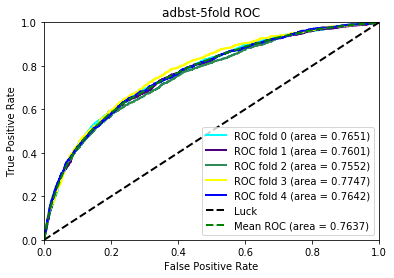

In [21]:
kfold_plot(train_val_x,train_val_y,adabst_model)

In [20]:
def kfold_plot(train_x, train_y, model):
    kf = StratifiedKFold(n_splits=5,random_state = 100)

    scores = []
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    exe_time = []
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue']
    #cmap = matplotlib.colors.ListedColormap(colors)
    lw = 2

    #flg,ax = plt.subplots(figsize = (8,5))
    i = 0
    for train_index,val_index in kf.split(train_x,train_y):
        t_X, v_X = train_x.iloc[train_index], train_x.iloc[val_index]
        t_y, v_y = train_y.iloc[train_index], train_y.iloc[val_index]
        begin_t = time.time()
        predictions = model(t_X,t_y,v_X)
        end_t = time.time()
        exe_time.append(round(end_t-begin_t, 3))
        scores.append(roc_auc_score(v_y.astype(float), predictions))
        fpr, tpr, thresholds = roc_curve(v_y, predictions)#?
        mean_tpr += interp(mean_fpr, fpr, tpr)#?
        mean_tpr[0] = 0.0#?
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=colors[i], label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
        i += 1
        print(ks(predictions,v_y))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
    mean_tpr /= kf.get_n_splits(train_val_x, train_val_y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)    
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.4f)' % mean_auc, lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('adbst-5fold ROC')
    plt.legend(loc='lower right')
    plt.savefig("adbst-5fold-ROC")
    plt.show()
    
def adabst_model(trainx,trainy,val_x):
    adabst_model = AdaBoostClassifier(n_estimators=500,learning_rate = 0.1,algorithm = "SAMME.R",random_state = 2) 
    adabst_model.fit(trainx,trainy)
    pred = adabst_model.predict_proba(val_x)
    return pred[:,1]
    
def ks(y_predicted, y_true):
    label=y_true
    #label = y_true.get_label()
    fpr,tpr,thres = metrics.roc_curve(label,y_predicted,pos_label=1)
    return 'ks',abs(fpr - tpr).max()